In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time, json
import sys
sys.path.append("../")
import os
import torch
import numpy as np
from tqdm import tqdm

import logging
from src.utils import logging_utils
from src.utils import env_utils, experiment_utils
from src import functional
import wandb

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-11-04 16:59:38 __main__ INFO     torch.__version__='2.5.0+cu124', torch.version.cuda='12.4'


In [3]:
from src.models import ModelandTokenizer

# MODEL_KEY = "meta-llama/Llama-3.2-3B-Instruct"
# MODEL_KEY = "meta-llama/Llama-3.1-8B-Instruct"

MODEL_KEY = "meta-llama/Llama-3.2-3B"
# MODEL_KEY = "google/gemma-2-2b"
# MODEL_KEY = "meta-llama/Llama-3.1-8B"

mt = ModelandTokenizer(
    model_key=MODEL_KEY,
    torch_dtype=torch.float32,
)

2024-11-04 16:59:39 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.82s/it]

2024-11-04 16:59:43 src.models INFO     loaded model </home/local_arnab/Codes/00_MODEL/meta-llama/Llama-3.2-3B> | size: 12255.675 MB | dtype: torch.float32 | device: cuda:0


2024-11-04 18:39:56 __main__ INFO     Initialized to [PredictedToken(token=' yellow', prob=0.7992479205131531, logit=68.48917388916016, token_id=14071), PredictedToken(token=' blue', prob=0.1817149966955185, logit=67.00794219970703, token_id=6437), PredictedToken(token=' purple', prob=0.015836581587791443, logit=64.56782531738281, token_id=25977), PredictedToken(token=' orange', prob=0.0027331539895385504, logit=62.81095886230469, token_id=19087), PredictedToken(token=' red', prob=0.00025385949993506074, logit=60.43452835083008, token_id=2579)]


100%|██████████| 100/100 [00:07<00:00, 12.86it/s]


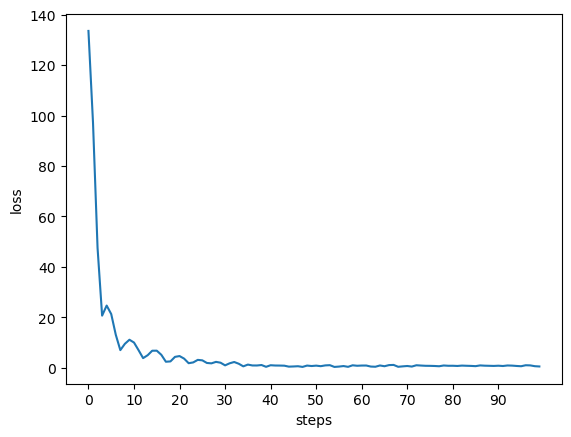

2024-11-04 18:40:04 __main__ INFO     Tuned to: [PredictedToken(token=' black', prob=0.10922465473413467, logit=14.7959623336792, token_id=3776), PredictedToken(token=' green', prob=0.09716958552598953, logit=14.6790132522583, token_id=6307), PredictedToken(token=' white', prob=0.09699598699808121, logit=14.677225112915039, token_id=4251), PredictedToken(token=' red', prob=0.09572141617536545, logit=14.663997650146484, token_id=2579), PredictedToken(token=' purple', prob=0.087739959359169, logit=14.576932907104492, token_id=25977)]


In [105]:
from typing import Optional
from tqdm import tqdm
from src.functional import get_module_nnsight, logit_lens, get_dummy_input
from matplotlib import pyplot as plt
from src.functional import interpret_logits


class CornerEstimator:
    mt: ModelandTokenizer
    layer_name: str
    verbose: bool = False

    def __init__(
        self,
        mt: ModelandTokenizer,
        layer_name: str,
        token_indices: Optional[list[int]] = None,
        verbose: bool = False
    ):
        self.mt = mt
        self.layer_name = layer_name
        self.token_indices = (
            list(range(mt.tokenizer.vocab_size))
            if token_indices is None
            else token_indices
        )
        self.verbose = verbose

    def initialize_with_lm_head_rows(self, token_indices: list[int] | None = None):
        token_indices = self.token_indices if token_indices is None else token_indices
        lm_head_weights = get_module_nnsight(self.mt, mt.lm_head_name).weight
        avg_embd = lm_head_weights[token_indices].detach().mean(dim=0).to(mt.device)

        if self.verbose:
            init_pred = self.evaluate(h=avg_embd, add_corner=False)
            logger.info(f"Initialized to {init_pred}")
        
        avg_embd.requires_grad = True
        return avg_embd

    def estimate(
        self, 
        token_indices: list[int] | None = None,
        target_logit: float = 15.0,
        n_steps: int = 100,
        learning_rate: float = 5e-2,
        weight_decay: float = 0,
    ):
        token_indices = self.token_indices if token_indices is None else token_indices
        corner = self.initialize_with_lm_head_rows(token_indices)

        optimizer = torch.optim.AdamW(
            [corner],
            lr=learning_rate,
            weight_decay=weight_decay,
        )

        # print(target.shape)

        inputs = mt.tokenizer(mt.tokenizer.bos_token, add_special_tokens=False, return_tensors="pt")
        mt._model.train()
        loss_track = []
        for iter in tqdm(range(n_steps)):
            with mt.trace(inputs) as tr:
                module = get_module_nnsight(mt, self.layer_name)
                module.output[0][0, :] = corner
                logits = mt.output.logits[0, -1].save()
            
            # print(f"{logits.shape=}, {target.shape=}")

            loss = (logits[token_indices] - target_logit).norm()
            loss_track.append(loss.item())

            optimizer.zero_grad()
            mt._model.zero_grad()
            
            loss.backward()
            optimizer.step()
        
        if self.verbose:
            plt.rcdefaults()
            plt.plot(loss_track)
            plt.xticks(range(0, len(loss_track), 10))
            plt.xlabel("steps")
            plt.ylabel("loss")
            plt.show()

            final_pred = self.evaluate(h=corner, add_corner=False)
            logger.info(f"Tuned to: {final_pred}")

        self.corner = corner.detach()
        return self.corner

    @torch.inference_mode()
    def evaluate(self, h: torch.Tensor, add_corner: bool = True):
        if add_corner:
            corner = (self.corner/self.corner.norm())*h.norm()
            logger.debug(f"{h.norm().item()=} | {corner.norm().item()=}")
            h = h + corner

        inputs = mt.tokenizer(mt.tokenizer.bos_token, add_special_tokens=False, return_tensors="pt")
        with mt.trace(inputs) as tr:
            module = get_module_nnsight(mt, estimator.layer_name)
            module.output[0][0, :] = h
            logits = mt.output.logits[0, -1].save()

        return interpret_logits(
            tokenizer=mt,
            logits=logits,
        )



estimator = CornerEstimator(
    mt, 
    mt.layer_name_format.format(mt.n_layer - 1),
    verbose=True

)

colors = [
    " red", 
    " green",
    " blue",
    " yellow",
    " orange",
    " purple",
    " white",
    " black",
]

token_indices = mt.tokenizer(colors, add_special_tokens=False, return_tensors="pt").input_ids.squeeze().tolist()
corner = estimator.estimate(token_indices = token_indices)

In [106]:
from src.tokens import prepare_input
from src.functional import get_hs

prompt = "Banana"
inputs = prepare_input("prompt", tokenizer=mt)

h_subj = get_hs(
    mt = mt,
    input = inputs,
    locations = (estimator.layer_name, -1),
)


estimator.evaluate(h_subj, add_corner=True)

2024-11-04 18:40:15 __main__ DEBUG    h.norm().item()=51.01571273803711 | corner.norm().item()=51.01571273803711


[PredictedToken(token=' blue', prob=0.1741441935300827, logit=14.425210952758789, token_id=6437),
 PredictedToken(token=' red', prob=0.1625315248966217, logit=14.356199264526367, token_id=2579),
 PredictedToken(token=' green', prob=0.14170628786087036, logit=14.219083786010742, token_id=6307),
 PredictedToken(token=' black', prob=0.10244597494602203, logit=13.894662857055664, token_id=3776),
 PredictedToken(token=' white', prob=0.04940338060259819, logit=13.165346145629883, token_id=4251)]

In [107]:
inputs

{'input_ids': tensor([[128000,  41681]], device='cuda:0'), 'attention_mask': tensor([[1, 1]], device='cuda:0')}